In [1]:
import pylab
import matplotlib.pyplot as plt
import numpy as np
import algorithms as algo

In [13]:
import pandas as pd
dataset='datasets/export'
files = ["L185_0_A9_1", "L185_0_A10_1",
         "L186_0_A11_1","L186_0_A12_1",
         "L187_0_B1_1", "L187_0_B2_1",
         "L291_0_A1_1", "L291_0_A2_1",
        ]
i = 2
print(f"{dataset}/{files[i]}.txt")
df= pd.read_table(f"{dataset}/{files[i]}.txt",
                  sep=" ", 
                  header=None,
                  names=['m/z', 'intensity']) 
df.head()

datasets/export/L186_0_A11_1.txt


,m/z,intensity
0,997.552,6966
1,997.646,6942
2,997.741,7003
3,997.836,7068
4,997.931,7122


In [3]:
x = df['m/z'].to_numpy()
y = df['intensity'].to_numpy()
print(x[:5])
print(y[:5])

[997.552 997.646 997.741 997.836 997.931]
[6279 6207 6192 6163 6157]


# Robust Peak Detection (with Z-Scores)

(-1.5, 1.5)

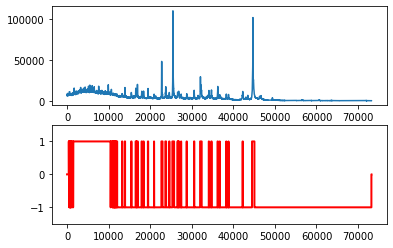

In [4]:
# Settings: lag = 30, threshold = 5, influence = 0
lag = 30
threshold = 5
influence = 0

# Run algo with settings from above
result = algo.thresholding_algo(y,
    lag=lag, 
    threshold=threshold, 
    influence=influence
)

# Plot result
pylab.subplot(211)
pylab.plot(np.arange(1, len(y)+1), y)
pylab.subplot(212)
pylab.step(np.arange(1, len(y)+1), result["signals"], color="red", lw=2)
pylab.ylim(-1.5, 1.5)

# SciPy: scipy.signal.find_peaks

In [5]:
from scipy.signal import find_peaks, peak_prominences

25


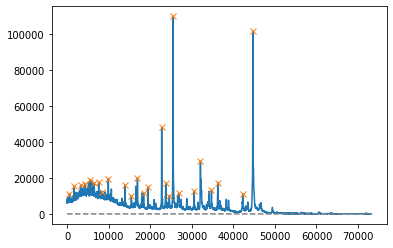

In [6]:
peaks, _ = find_peaks(y,distance=800, height=10000)
print(len(peaks))
plt.plot(y)
plt.plot(peaks, y[peaks], "x")
plt.plot(np.zeros_like(y), "--", color="gray")
plt.show()

In [7]:
prominences = peak_prominences(y, peaks)[0]
prominences

array([  4673.,   7871.,   6403.,   6750.,  11391.,   7017.,   9274.,
         3611.,  13528.,  11740.,   6590.,  16596.,   8672.,  12311.,
        45083.,  14030.,   6675., 107489.,   8094.,  10429.,  27050.,
        10805.,  15395.,   9809., 100763.])

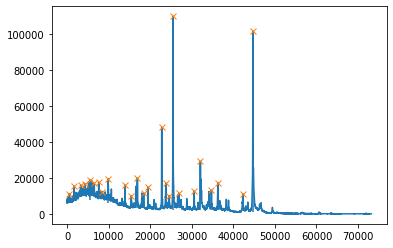

In [8]:
contour_heights = y[peaks] - prominences
plt.plot(y)
plt.plot(peaks, y[peaks], "x")
plt.vlines(x=peaks, ymin=contour_heights, ymax=y[peaks])
plt.show()

# Persistent Topology for Peak Detection

In [9]:
pt_peaks = algo.get_persistent_homology(y)
for i, pk in enumerate(pt_peaks):
    print(f'{i}:{pk.born},{pk.left},{pk.right},{pk.died}:\t{y[pk.born]}')
    if i > 10:
        break

0:25471,0,73215,None:	109916
1:44715,41386,47643,41385:	101723
2:22767,22485,23389,23390:	48089
3:32090,28298,35504,28297:	29304
4:16936,0,21880,21881:	19946
5:9922,0,15083,15084:	19513
6:36257,35573,37835,35572:	17450
7:23743,23393,24885,24886:	17156
8:19483,19041,21848,19040:	14929
9:13929,13583,14242,13582:	16130
10:5480,2163,8978,8979:	19107
11:34744,33244,35491,33243:	13164


In [10]:
peaks = sorted([pk.born for pk in pt_peaks if y[pk.born]>15000] )
print(peaks[:10])
print(len(peaks))

[1712, 1722, 3267, 3274, 4044, 4046, 4050, 4055, 4183, 4185]
61


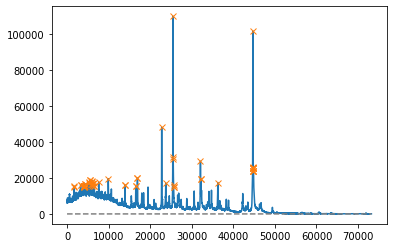

In [11]:
plt.plot(y)
plt.plot(peaks, y[peaks], "x")
plt.plot(np.zeros_like(y), "--", color="gray")
plt.show()